In [1]:
!pip install lightgbm tabulate


In [2]:
import numpy as np
import pandas as pd
import gc
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, MonthLocator
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
CONFIG = {
    'data_path': "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/final_m5_model_data.parquet",
    'model_path': "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/models/final_m5_model_lightgbm_tuned.json",
    'validation_days': 28
}

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [6]:
print("Loading data...")
df = pd.read_parquet(CONFIG['data_path'])
df = reduce_mem_usage(df)

cat_features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'
]

print("Converting categorical features to 'category' type...")
for col in cat_features:
    df[col] = df[col].astype('category')

print("Sorting dataframe by date...")
df = df.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)

split_date = df['date'].unique()[-CONFIG['validation_days']]
print(f"Splitting data at date: {split_date}")

mask_train = df['date'] < split_date
mask_valid = df['date'] >= split_date

print("Creating validation dataframe for plotting...")
valid_df = df.loc[mask_valid, ['date', 'state_id', 'sales']].copy()

Loading data...
Memory usage decreased to 6063.33 Mb (39.8% reduction)
Converting categorical features to 'category' type...
Sorting dataframe by date...
Splitting data at date: 2016-04-25 00:00:00
Creating validation dataframe for plotting...


In [7]:
features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI',
    'wday', 'month', 'year', 'quarter', 'week',
    'day_of_week', 'day_of_month', 'day_of_year', 'weekend',
    'month_sin', 'month_cos',
    'day_of_month_sin', 'day_of_month_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'sell_price', 'price_mean', 'price_relative_to_mean',
    'price_change_lag', 'price_lag_7', 'price_lag_28',
    'sales_lag_1', 'sales_lag_7', 'sales_lag_28',
    'sales_rolling_mean_7', 'sales_rolling_mean_28'
]

print("Preparing prediction features...")
X_valid = df.loc[mask_valid, features]

print("Extracting recent training history for visualization...")
train_cutoff_date = pd.to_datetime(split_date) - pd.Timedelta(days=90)
mask_hist = (df['date'] >= train_cutoff_date) & (df['date'] < split_date)
hist_df = df.loc[mask_hist, ['date', 'state_id', 'sales']].copy()

del df, mask_train, mask_valid, mask_hist
gc.collect()

print("Data preparation complete.")

Preparing prediction features...
Extracting recent training history for visualization...
Data preparation complete.


In [8]:
print(f"Loading LightGBM model from {CONFIG['model_path']}...")
bst = lgb.Booster(model_file=CONFIG['model_path'])

print("Generating predictions...")
preds = bst.predict(X_valid)

valid_df['forecast'] = preds

Loading LightGBM model from /content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/models/final_m5_model_lightgbm_tuned.json...
Generating predictions...


Generating Visualization...


/tmp/ipython-input-4287046917.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_agg = hist_df.groupby(['date', 'state_id'])['sales'].sum().reset_index()
/tmp/ipython-input-4287046917.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_agg = valid_df.groupby(['date', 'state_id'])['sales'].sum().reset_index()
/tmp/ipython-input-4287046917.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  forecast_agg = va

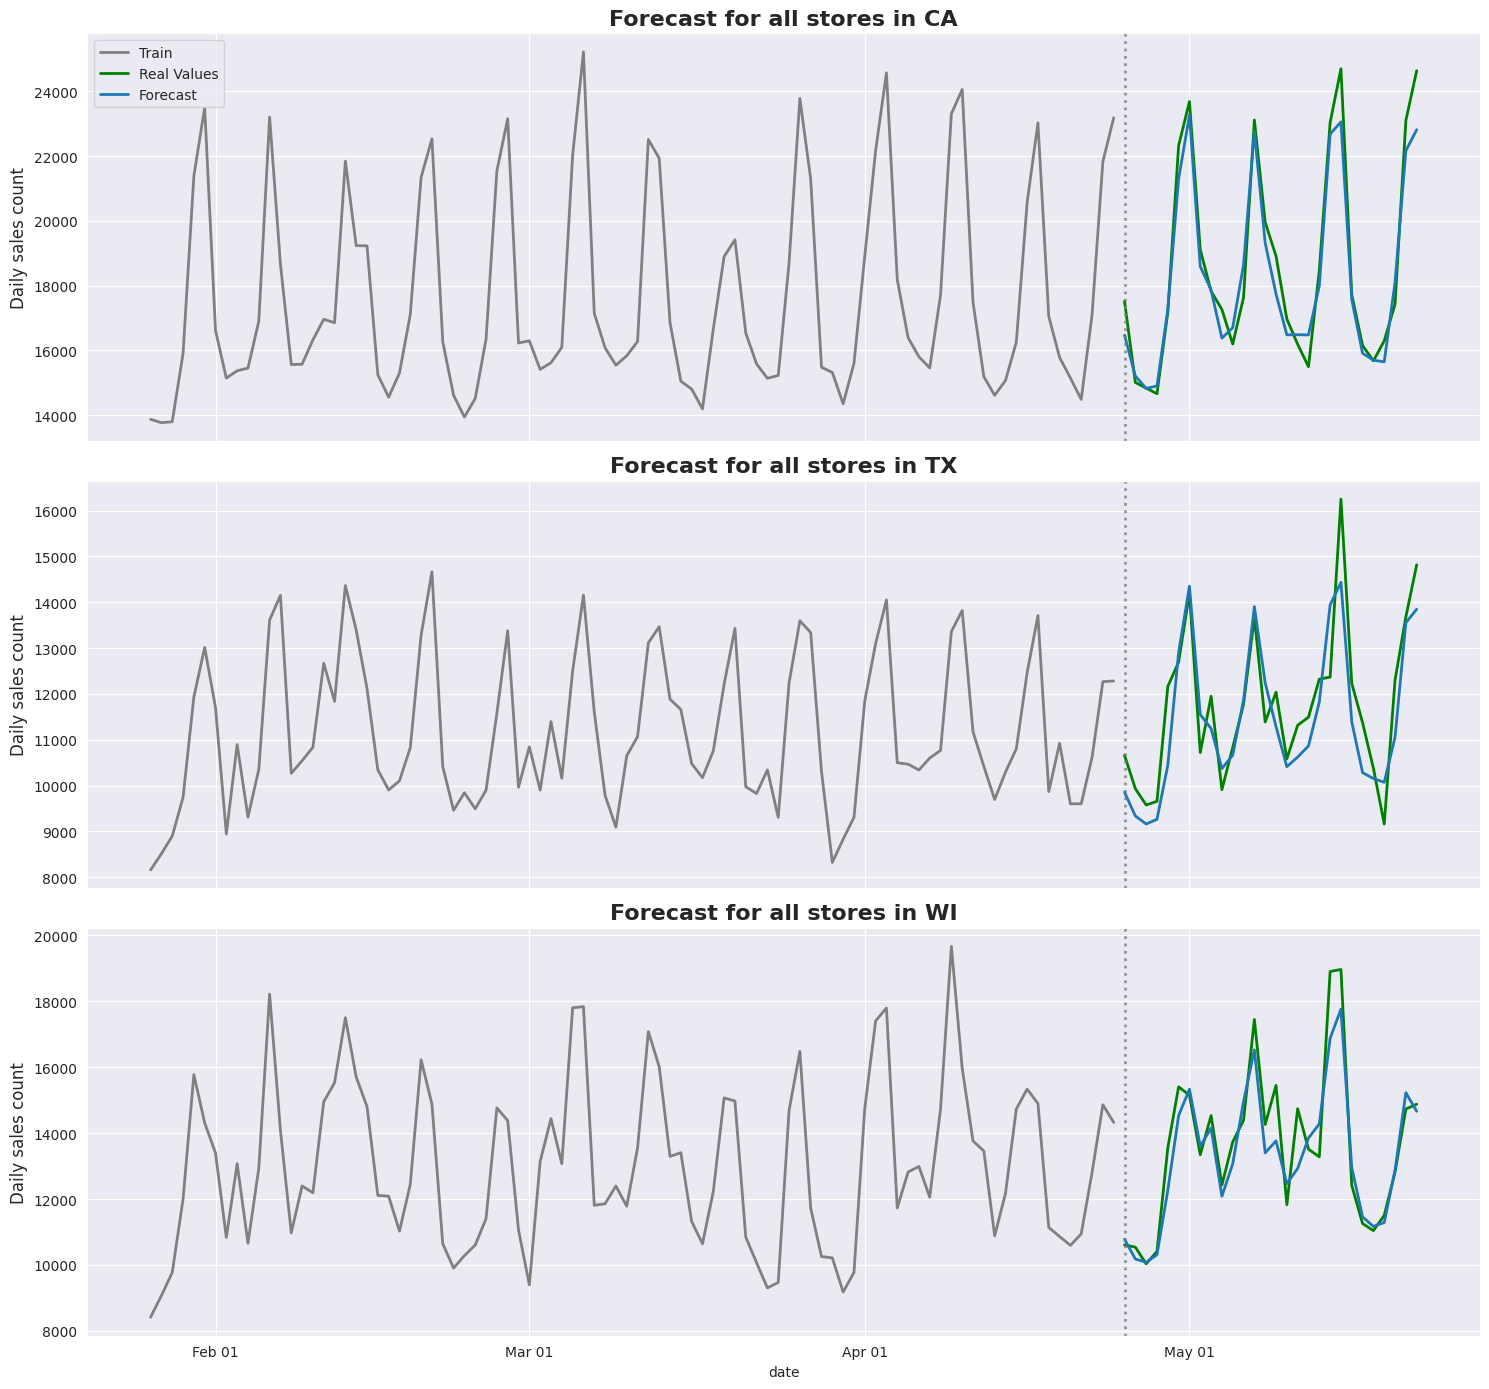

In [9]:
print("Generating Visualization...")

train_agg = hist_df.groupby(['date', 'state_id'])['sales'].sum().reset_index()
train_agg['type'] = 'Train'

valid_agg = valid_df.groupby(['date', 'state_id'])['sales'].sum().reset_index()
valid_agg['type'] = 'Real Values'

forecast_agg = valid_df.groupby(['date', 'state_id'])['forecast'].sum().reset_index()
forecast_agg = forecast_agg.rename(columns={'forecast': 'sales'})
forecast_agg['type'] = 'Forecast'

plot_data = pd.concat([train_agg, valid_agg, forecast_agg], ignore_index=True)

sns.set_style("darkgrid")
states = ['CA', 'TX', 'WI']
custom_palette = {'Train': 'grey', 'Real Values': 'green', 'Forecast': '#1f77b4'}

fig, axes = plt.subplots(3, 1, figsize=(15, 14), sharex=True)

for i, state in enumerate(states):
    ax = axes[i]

    state_data = plot_data[plot_data['state_id'] == state]

    sns.lineplot(
        data=state_data,
        x='date', y='sales', hue='type',
        palette=custom_palette, linewidth=2.0, ax=ax
    )

    ax.axvline(pd.to_datetime(split_date), color='grey', linestyle=':', linewidth=2, alpha=0.8)

    ax.set_title(f'Forecast for all stores in {state}', fontsize=16, fontweight='bold')
    ax.set_ylabel('Daily sales count', fontsize=12)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

    if i == 0:
        ax.legend(loc='upper left', frameon=True, fontsize=10)
    else:
        if ax.get_legend(): ax.get_legend().remove()

plt.tight_layout()
plt.show()